In [2]:
%pip install folium

Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 26.9 MB/s eta 0:00:0000:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 21.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


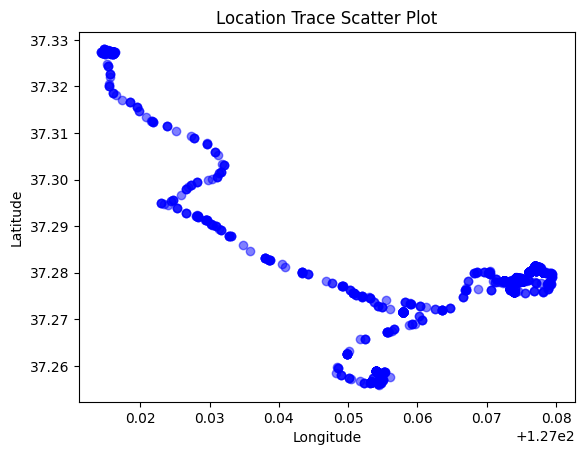

In [1]:
import folium
import json
import matplotlib.pyplot as plt

with open("../data/locations.json", "r") as f:
    data = json.loads(f.read())
# 위치 데이터를 파싱
locations = []
for entry in data["locations"]:
    timestamp, coords = entry.split(": ")
    lat, lon = map(float, coords.split(", "))
    locations.append((int(timestamp), lat, lon))

# Folium 맵 객체 생성
m = folium.Map(location=[locations[0][1], locations[0][2]], zoom_start=15)

# 초기값 설정
TIME_INTERVAL = 30  # 30초
current_time = locations[0][0]
current_lat = locations[0][1]
current_lon = locations[0][2]
points = [[current_lat, current_lon]]
marker_counts = {(current_lat, current_lon): 1}

for i in range(1, len(locations)):
    timestamp, lat, lon = locations[i]
    
    # 이전 위치에서 새로운 위치로 이동하는 동안의 시간을 확인
    while current_time + TIME_INTERVAL < timestamp:
        current_time += TIME_INTERVAL
        points.append([current_lat, current_lon])
        marker_counts[(current_lat, current_lon)] = marker_counts.get((current_lat, current_lon), 0) + 1
    
    current_time = timestamp
    current_lat = lat
    current_lon = lon
    points.append([lat, lon])
    marker_counts[(lat, lon)] = marker_counts.get((lat, lon), 0) + 1

# 점 추가 및 색상 설정
max_count = max(marker_counts.values())
for (lat, lon), count in marker_counts.items():
    opacity = count / max_count
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=opacity,
        popup=str(current_time)  # 팝업에 타임스탬프 추가
    ).add_to(m)

# 경로를 선으로 연결
folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(m)

# 산점도 그리기
lats, lons = zip(*points)
plt.scatter(lons, lats, c='blue', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Location Trace Scatter Plot')
plt.savefig('scatter_plot.png')

# 지도 저장
m.save('location_trace.html')

In [2]:
import folium
import pandas as pd
import json
from datetime import datetime

with open("../data/locations.json", "r") as f:
    data = json.loads(f.read())

# 데이터 프레임으로 변환
locations = []
for loc in data["locations"]:
    timestamp, coord = loc.split(": ")
    latitude, longitude = map(float, coord.split(", "))
    timestamp = datetime.strptime(timestamp, '%H%M%S')
    locations.append((timestamp, latitude, longitude))

df = pd.DataFrame(locations, columns=["timestamp", "latitude", "longitude"])
df.head()


,timestamp,latitude,longitude
0,1900-01-01 00:00:45,37.280641,127.077029
1,1900-01-01 00:01:32,37.280236,127.076093
2,1900-01-01 00:42:22,37.278871,127.074413
3,1900-01-01 00:42:59,37.280414,127.076413
4,1900-01-01 10:44:02,37.279927,127.078992


In [4]:
# 맵 생성
m = folium.Map(location=[df["latitude"].mean(), df["longitude"].mean()], zoom_start=13)

radius = 0
# 포인트 추가
prev_timestamp = None
for index, row in df.iterrows():
    if prev_timestamp is not None:
        interval = (row["timestamp"] - prev_timestamp).total_seconds()
        radius = min(interval / 6, 30)  # interval 값에 비례하여 반지름 설정, 최대 30으로 제한
    
    start = prev_timestamp.strftime("%H:%M:%S") if prev_timestamp is not None else "Start"
    end = row["timestamp"].strftime("%H:%M:%S")
    
    folium.CircleMarker(
        location=(row["latitude"], row["longitude"]),
        radius=radius,
        color='blue',
        fill=True,
        fill_color='blue',
        popup=f"{start} - {end}",
        fill_opacity=0.3,
    ).add_to(m)
    
    prev_timestamp = row["timestamp"]

# 첫 번째 점 강조
first_row = df.iloc[0]
folium.CircleMarker(
    location=(first_row["latitude"], first_row["longitude"]),
    radius=5,
    color='greed',
    fill=True,
    fill_color='green',
    popup=df.iloc[0]["timestamp"].strftime("%H:%M:%S"),
    fill_opacity=1.0
).add_to(m)

# 마지막 점 강조
last_row = df.iloc[-1]
folium.CircleMarker(
    location=(last_row["latitude"], last_row["longitude"]),
    radius=5,
    color='red',
    fill=True,
    fill_color='red',
    popup=df.iloc[-1]["timestamp"].strftime("%H:%M:%S"),
    fill_opacity=1.0
).add_to(m)

folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(m)

# 맵 저장
m.save("map.html")